In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, GlobalAveragePooling1D, BatchNormalization, Flatten, Reshape
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [285]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
49479,augustin cria,Romance
28118,mellontiko barono,Hellenic
55116,incartade put advenir,Romance
53284,lampe eclairait la,Romance
1460,mas dinetai e,Hellenic


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [286]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Rows: 128408
Amount of languages to identify: 4


In [287]:
model = Sequential()
model.add(Conv1D(input_dim, (input_dim/2).__ceil__(), activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(12, activation='relu')
model.add(LSTM(128, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [288]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=2048,verbose=1)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.2869 - loss: 1.5618 - val_accuracy: 0.3005 - val_loss: 1.3539
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.3754 - loss: 1.2949 - val_accuracy: 0.4627 - val_loss: 1.1750
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.4797 - loss: 1.1496 - val_accuracy: 0.4949 - val_loss: 1.1227
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5103 - loss: 1.1020 - val_accuracy: 0.5343 - val_loss: 1.0606
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.5357 - loss: 1.0599 - val_accuracy: 0.5259 - val_loss: 1.0778
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5413 - loss: 1.0490 - val_accuracy: 0.5762 - val_loss: 0.9880
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.5617 - loss: 1.0122 - val_accuracy: 0.5988 - val_loss: 0.9493
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5877 - loss: 0.9675 - val_accuracy: 0.

Text(0.5, 0, 'Epoch')

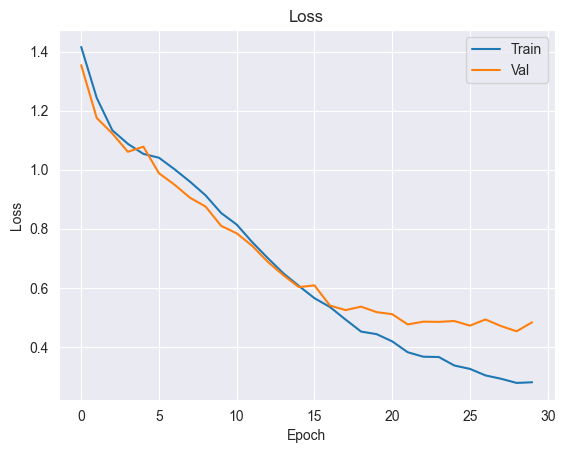

In [289]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Prediction

In [309]:
prediction_word = ""
prediction_word = preprocess(prediction_word)
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Language_Germanic: 82.8
Language_Hellenic: 0.0
Language_Romance: 17.2
Language_Slavic: 0.0


In [291]:
model.save('./model.keras')